# About
An implementation of a Conditional GAN on the anime scratch colorization dataset.  
Useful refs:  
1) https://arxiv.org/abs/1611.07004 - Image-to-Image Translation with Conditional Adversarial Networks.  
2) https://www.youtube.com/watch?v=SuddDSqGRzg&ab_channel=AladdinPersson - tutorial of the implementation.

My goal in this work is to gain an understanding of the PatchGAN discriminator implementation and implement Conditional GAN.

In [1]:
try:
    import lightning
except ImportError:
    !pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.1 MB/s eta 0:00:00


In [2]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

 Dataset: https://www.kaggle.com/datasets/ktaebum/anime-sketch-colorization-pair

You have to load a .env with parameters below:

In [3]:
from dotenv import load_dotenv
import os

load_dotenv('.env')

NGROC_TOKEN = os.getenv("NGROC_TOKEN")
PATH_TO_DATA_ROOT = os.getenv("PATH_TO_DATA_ROOT")
PATH_TO_CHECKPOINT = os.getenv("PATH_TO_CHECKPOINT") # after train you will have checkpoints
WORKING_IMAGE_SIZE = int(os.getenv("WORKING_IMAGE_SIZE", 256))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 4))
BETAS1 = float(os.getenv("BETAS1", 0.5))
BETAS2 = float(os.getenv("BETAS2", 0.999))
LEARNING_RATE = float(os.getenv("LEARNING_RATE", 2e-4))
BETAS = (BETAS1, BETAS2)
L1_LAMBDA = int(os.getenv("L1_LAMBDA", 100))

In [4]:
BATCH_SIZE = 16

In [5]:
PATH_TO_DATA_ROOT = '/kaggle/input/anime-sketch-colorization-pair/data/'
NGROC_TOKEN = '2fG10zp98XxtDfwfvziql1mzDht_2Yb75vHHYtRB7qHEPzkqJ'
PATH_TO_CHECKPOINT ='/kaggle/input/p2p/pytorch/default/1/kaggle/working/lightning_logs/version_0/checkpoints/epoch=49-step=88900.ckpt'
L1_LAMBDA = 1

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from lightning.pytorch import loggers as pl_loggers
from torchvision.utils import make_grid

In [7]:
!rm -r /kaggle/working/pytorch-anime-style-transfer
!git clone https://github.com/ThViviani/pytorch-anime-style-transfer.git

import sys
sys.path.append('/kaggle/working/pytorch-anime-style-transfer')

rm: cannot remove '/kaggle/working/pytorch-anime-style-transfer': No such file or directory
Cloning into 'pytorch-anime-style-transfer'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 219 (delta 140), reused 139 (delta 66), pack-reused 0 (from 0)
Receiving objects: 100% (219/219), 3.33 MiB | 31.61 MiB/s, done.
Resolving deltas: 100% (140/140), done.


# Data loading

(512, 1024, 3)


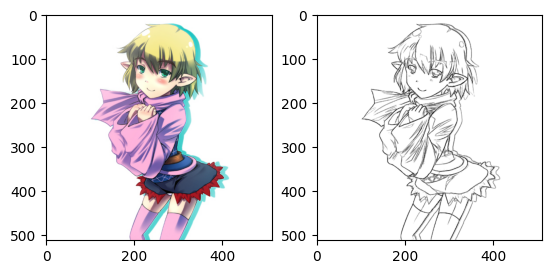

In [8]:
train_files = os.listdir(PATH_TO_DATA_ROOT + "train")
img_file = train_files[0]
img_path = os.path.join(PATH_TO_DATA_ROOT + "train", img_file)
img = np.array(Image.open(img_path))
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[:, :512, :])
ax[1].imshow(img[:, 512:, :])

In [9]:
class AnimeSketchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        target_image = image[:, :512, :]
        input_image = image[:, 512:, :]

        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)

        transform = transforms.Compose([
            transforms.Resize((WORKING_IMAGE_SIZE, WORKING_IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        input_image = transform(input_image)
        target_image = transform(target_image)

        return input_image, target_image

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

class MyDataModule(L.LightningDataModule):
    def __init__(self, train_root, val_root, batch_size):
        super().__init__()
        self.train_root = train_root
        self.val_root = val_root
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = AnimeSketchDataset(self.train_root)
        self.val_dataset = AnimeSketchDataset(self.val_root)
        # subset_indices = list(range(10))
        # self.train_dataset = Subset(self.train_dataset, subset_indices)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [11]:
train_dataset = AnimeSketchDataset(PATH_TO_DATA_ROOT + "train")
val_dataset = AnimeSketchDataset(PATH_TO_DATA_ROOT + "val")

In [12]:
len(train_dataset), len(val_dataset)

(14224, 3545)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

In [14]:
len(train_loader), len(val_loader)

(889, 222)


# Model fitting

The conditional GANs learn a mapping from observed image $x$ and random noise vector $z$, to $y$, $G : {x,z} → y$. The generator $G$ is trained to produce outputs that cannot be distinguished from “real” images by an adversarially trained discriminator, $D$, which is trained to do as well as possible at detecting the generator’s “fakes”.

The objective of a conditional GAN can be expressed as  
$\mathcal{L}_{cGAN}(G, D) = \mathbb{E}_{x,y} [\log D(x, y)] + \mathbb{E}_{x, z} [\log(1 - D(x, G(x, z)))]
$.

Previous approaches have found it beneficial to mix the GAN objective with a more traditional loss, such as L2 distance or L1  
$\mathcal{L}_{L1}(G) = \mathbb{E}_{x,y,z} [||y - G(x, z)||_1]
$.

Final optimization task:  
$G^* = arg min_{G} max_{D} \mathcal{L}_{cGAN}(G, D) + \lambda \mathcal{L}_{L1}(G)$

In [15]:
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F

from src.data.utils import denorm_tensor
from torch.amp import autocast


class ConditionalGAN_hat(L.LightningModule):
    """Defines a Conditional GAN"""

    def __init__(self, discriminator=None, generator=None, opt=None):
        """Construct a Conditional GAN
        Parameters:
            discriminator (Discriminator class) -- the Discriminator for the cGAN; Discriminator class: PatchDiscriminator | ...
            generator (Generator class) -- the Generator for the cGAN; Generator class: UnetGenerator | ...
            opt (Option class)-- stores all the experiment flags
        """

        super().__init__()

        self.discriminator = discriminator
        self.generator = generator
        self.automatic_optimization = False
        self.opt=opt

    def training_step(self, batch, batch_idx):
        x, y = batch
        d_optimizer, g_optimizer = self.optimizers()
        bce = nn.BCEWithLogitsLoss()

        # TRAIN DISCRIMINATOR
        self.discriminator.zero_grad()

        # forward pass with real batch
        d_output_real = self.discriminator(torch.concat([x, y], dim=1))
        real_labels = torch.ones_like(d_output_real, device=self.device)
        d_real_error = bce(d_output_real, real_labels)

        # forward pass with fake images
        fake_images = self.generator(x)
        d_output_fake = self.discriminator(torch.concat([x, fake_images], dim=1))
        fake_labels = torch.zeros_like(d_output_fake, device=self.device)
        d_fake_error = bce(d_output_fake, fake_labels)

        # update discriminator
        d_error_full = (d_real_error + d_fake_error) / 2.0
        self.manual_backward(d_error_full)
        d_optimizer.step()

        # TRAIN GENERATOR
        self.generator.zero_grad()

        fake_images = self.generator(x)
        d_output_fake = self.discriminator(torch.concat([x, fake_images], dim=1))
        real_labels = torch.ones_like(d_output_fake, device=self.device)
        g_error = bce(d_output_fake, real_labels)

        l1_error = F.l1_loss(fake_images, y) * self.opt.l1_lambda
        g_error += l1_error

        # update generator
        self.manual_backward(g_error)
        g_optimizer.step()

        history = {'loss_d': d_error_full.item(), 'loss_g': g_error.item()}
        self.log_dict(history, prog_bar=True)

        # saved generated images
        if batch_idx == len(self.trainer.datamodule.train_dataloader()) - 1:
            val_dataloader = self.trainer.datamodule.val_dataloader()
            x_val, y_val = next(iter(val_dataloader))
            x_val = x_val.to(self.device)
            y_val = y_val.to(self.device)
            with autocast(device_type=self.device.type):
              val_image = torch.concat([self.generator(x_val), y_val], dim=0)

            tensorboard = self.logger.experiment
            tensorboard.add_images(
                "train_generated_images",
                denorm_tensor(
                    torch.concat([self.generator(x), y], dim=0),
                    [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
                    self.device
                ),
                self.current_epoch
            )
            tensorboard.add_images(
                "val_generated_images",
                denorm_tensor(
                    val_image,
                    [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
                    self.device
                ),
                self.current_epoch
            )

        return history

    def configure_optimizers(self):
        discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.opt.lr,
            betas=self.opt.betas
        )

        generator_optimizer = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.opt.lr,
            betas=self.opt.betas
        )
        return [discriminator_optimizer, generator_optimizer]

In [16]:
from src.data import utils
from src.models import *

# cgan = ConditionalGAN(
#      define_discriminator(6, 64, norm_layer=nn.BatchNorm2d),
#      define_generator(3, 64, norm_layer=nn.BatchNorm2d),
#      TrainOptions(l1_lambda=L1_LAMBDA)
#  )

cgan = ConditionalGAN.load_from_checkpoint(
   PATH_TO_CHECKPOINT,
   generator=define_generator(3, 64, norm_layer=nn.BatchNorm2d),
   discriminator=define_discriminator(6, 64, norm_layer=nn.BatchNorm2d),
   map_location=torch.device('cpu'),
   opt=TrainOptions(l1_lambda=L1_LAMBDA)
)

data_module = MyDataModule(PATH_TO_DATA_ROOT + "train", PATH_TO_DATA_ROOT + "val", BATCH_SIZE)

## Visualize experiments and training process

In [17]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xf ./ngrok-v3-stable-linux-amd64.tgz -C /usr/local/bin

--2024-12-23 18:40:25--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 99.83.220.108, 13.248.244.96, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|99.83.220.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14809556 (14M) [application/octet-stream]
Saving to: 'ngrok-v3-stable-linux-amd64.tgz'

ngrok-v3-stable-lin 100%[===================>]  14.12M  18.6MB/s    in 0.8s    

2024-12-23 18:40:27 (18.6 MB/s) - 'ngrok-v3-stable-linux-amd64.tgz' saved [14809556/14809556]



In [18]:
!ngrok authtoken $NGROC_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [19]:
import os
import multiprocessing

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./lightning_logs --load_fast=false --host 0.0.0.0 --port 6006 &",
                        "/usr/local/bin/ngrok http 6006 &"
                        ]]

In [20]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0419-34-105-1-139.ngrok-free.app


In [21]:
print(torch.cuda.is_initialized())

False


In [22]:
tensorboard = pl_loggers.TensorBoardLogger(save_dir="")
trainer = L.Trainer(max_epochs=50, logger=tensorboard, precision="16-mixed", strategy="ddp_notebook")
trainer.fit(model=cgan, datamodule=data_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | discriminator | PatchDiscriminator | 2.8 M  | train
1 | generator     | UnetGenerator      | 54.4 M |

Training: |          | 0/? [00:00<?, ?it/s]

TensorBoard 2.16.2 at http://0.0.0.0:6006/ (Press CTRL+C to quit)
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


In [23]:
import os
import io
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from PIL import Image

def extract_train_images(log_dir, output_dir="extracted_images"):
    # Создаем папку для сохранения изображений
    os.makedirs(output_dir, exist_ok=True)

    # Найти файл логов
    event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out")]
    if not event_files:
        raise FileNotFoundError("No event files found in the log directory!")
    event_file = os.path.join(log_dir, event_files[0])

    # Загрузка событий из файла
    event_acc = EventAccumulator(event_file, size_guidance={"images": 0})
    event_acc.Reload()

    # Извлекаем ключи категорий (включая изображения)
    tags = event_acc.Tags()["images"]

    # Сохраняем изображения по тегам
    for tag in tags:
        events = event_acc.Images(tag)
        print(len(events))
        for i, event in enumerate(events):
          image_data = event.encoded_image_string
          image = Image.open(io.BytesIO(image_data))
          image.save(os.path.join(output_dir, f"{tag}_epoch_{i}.png"))
          print(f"Saved {tag}_epoch_{i}.png")

    print(f"Images have been saved to {output_dir}")

In [24]:
extract_train_images(log_dir="/kaggle/working/lightning_logs/version_0/")

50
Saved train_generated_images_epoch_0.png
Saved train_generated_images_epoch_1.png
Saved train_generated_images_epoch_2.png
Saved train_generated_images_epoch_3.png
Saved train_generated_images_epoch_4.png
Saved train_generated_images_epoch_5.png
Saved train_generated_images_epoch_6.png
Saved train_generated_images_epoch_7.png
Saved train_generated_images_epoch_8.png
Saved train_generated_images_epoch_9.png
Saved train_generated_images_epoch_10.png
Saved train_generated_images_epoch_11.png
Saved train_generated_images_epoch_12.png
Saved train_generated_images_epoch_13.png
Saved train_generated_images_epoch_14.png
Saved train_generated_images_epoch_15.png
Saved train_generated_images_epoch_16.png
Saved train_generated_images_epoch_17.png
Saved train_generated_images_epoch_18.png
Saved train_generated_images_epoch_19.png
Saved train_generated_images_epoch_20.png
Saved train_generated_images_epoch_21.png
Saved train_generated_images_epoch_22.png
Saved train_generated_images_epoch_23.png

In [25]:
!cd /kaggle/working/extracted_images 
!zip -r ./images.zip ./extracted_images

from IPython.display import FileLink 

FileLink("images.zip")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: extracted_images/ (stored 0%)
  adding: extracted_images/val_generated_images_epoch_0.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_30.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_6.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_2.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_36.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_49.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_7.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_28.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_21.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_7.png (deflated 0%)
  adding: extracted_images/val_generated_images_epoch_9.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_18.png (deflated 0%)
  adding: extracted_images/train_generated_images_epoch_

/kaggle/working/images.zip

In [26]:
!cd /kaggle/working/lightning_logs/version_0/checkpoints && ls -l

total 670272
-rw------- 1 root root 686353938 Dec 24 00:58 'epoch=49-step=88900.ckpt'


In [27]:
!cd /kaggle/working/lightning_logs/version_0
!zip -r ./conditional_gan_checkpoint.zip /kaggle/working/lightning_logs/version_0/checkpoints
FileLink(f'conditional_gan_checkpoint_{L1_LAMBDA}.zip')

  adding: kaggle/working/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: kaggle/working/lightning_logs/version_0/checkpoints/epoch=49-step=88900.ckpt (deflated 15%)


/kaggle/working/conditional_gan_checkpoint_1.zip

## Inference

In [28]:
# cGAN = ConditionalGAN.load_from_checkpoint(
#    PATH_TO_CHECKPOINT,
#    generator=define_generator(3, 64, norm_layer=nn.InstanceNorm2d),
#    discriminator=define_discriminator(6, 64, norm_layer=nn.InstanceNorm2d)
# ).cpu()

cGAN = cgan
cGAN.eval()

ConditionalGAN(
  (discriminator): PatchDiscriminator(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): DiscriminatorCNNBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): DiscriminatorCNNBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): DiscriminatorCNNBlock(
        (conv): Sequential(
          (0): Conv2d(256, 512, k

In [29]:
def show_some_examples(model, dataset, n=5):
  _, axes = plt.subplots(n, 3, figsize=(10, 15))

  for i in range(n):
    x, y = dataset[np.random.randint(0, len(dataset))]
    y_hat = model.generator(x.unsqueeze(0))

    y_hat = utils.denorm_tensor(y_hat, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)
    y = utils.denorm_tensor(y, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)
    x = utils.denorm_tensor(x, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device=cGAN.device)

    y_hat = y_hat.squeeze(0).permute(1, 2, 0).detach().numpy()
    y = y.squeeze(0).permute(1, 2, 0).detach().numpy()
    x = x.squeeze(0).permute(1, 2, 0).detach().numpy()

    for ax in axes[i]:
      ax.axis('off')

    axes[i][0].imshow(x)
    axes[i][0].set_title("input")
    axes[i][1].imshow(y)
    axes[i][1].set_title("true")
    axes[i][2].imshow(y_hat)
    axes[i][2].set_title("predicted")

  plt.show()

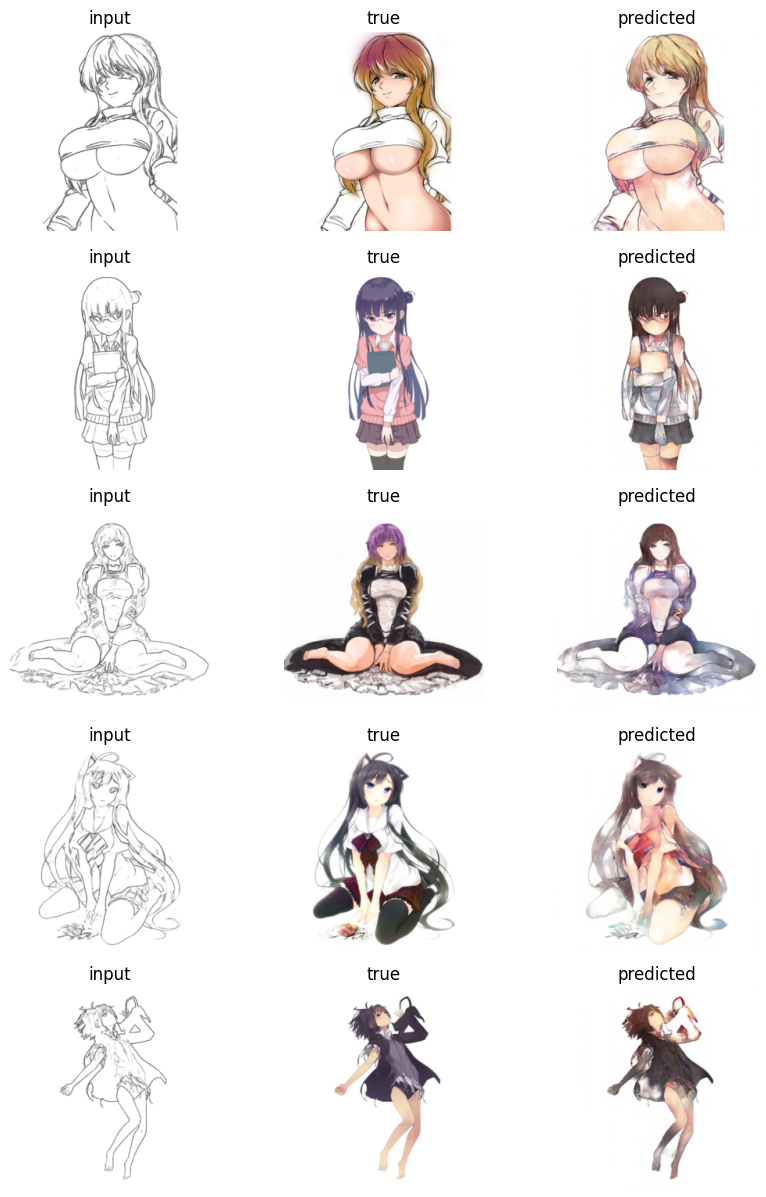

In [30]:
show_some_examples(cGAN, val_dataset)

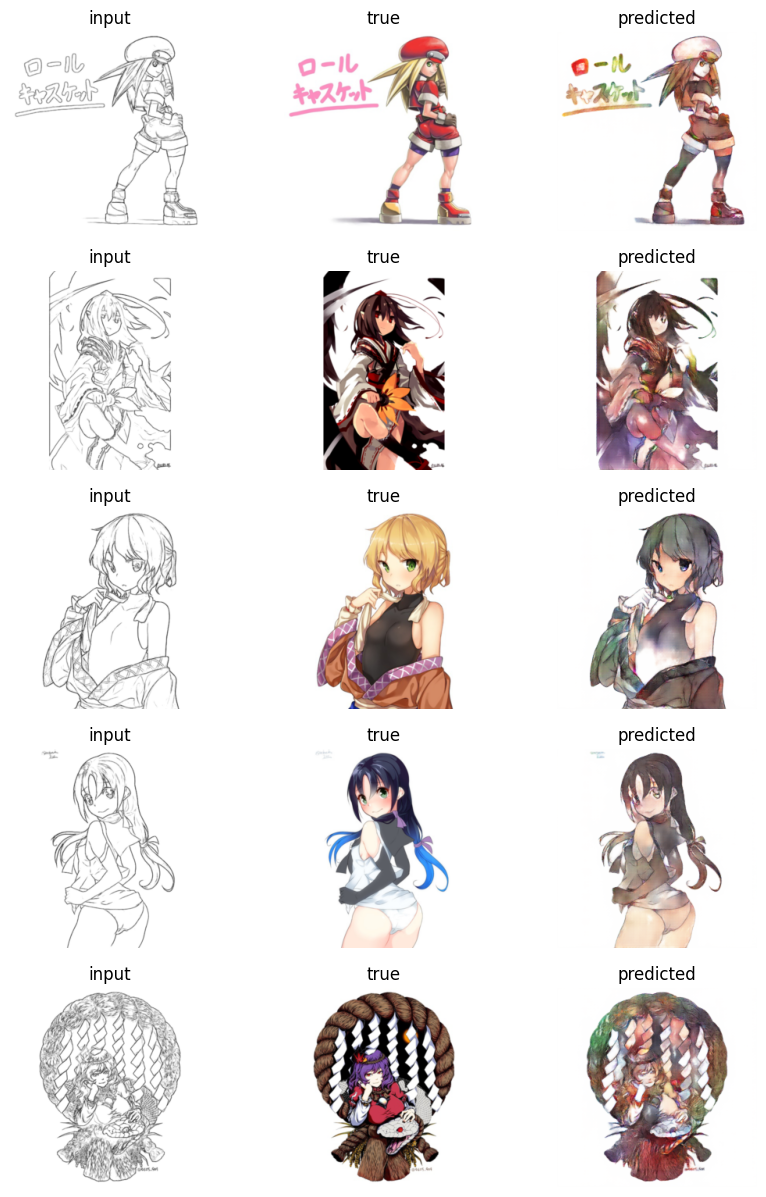

In [31]:
show_some_examples(cGAN, val_dataset)

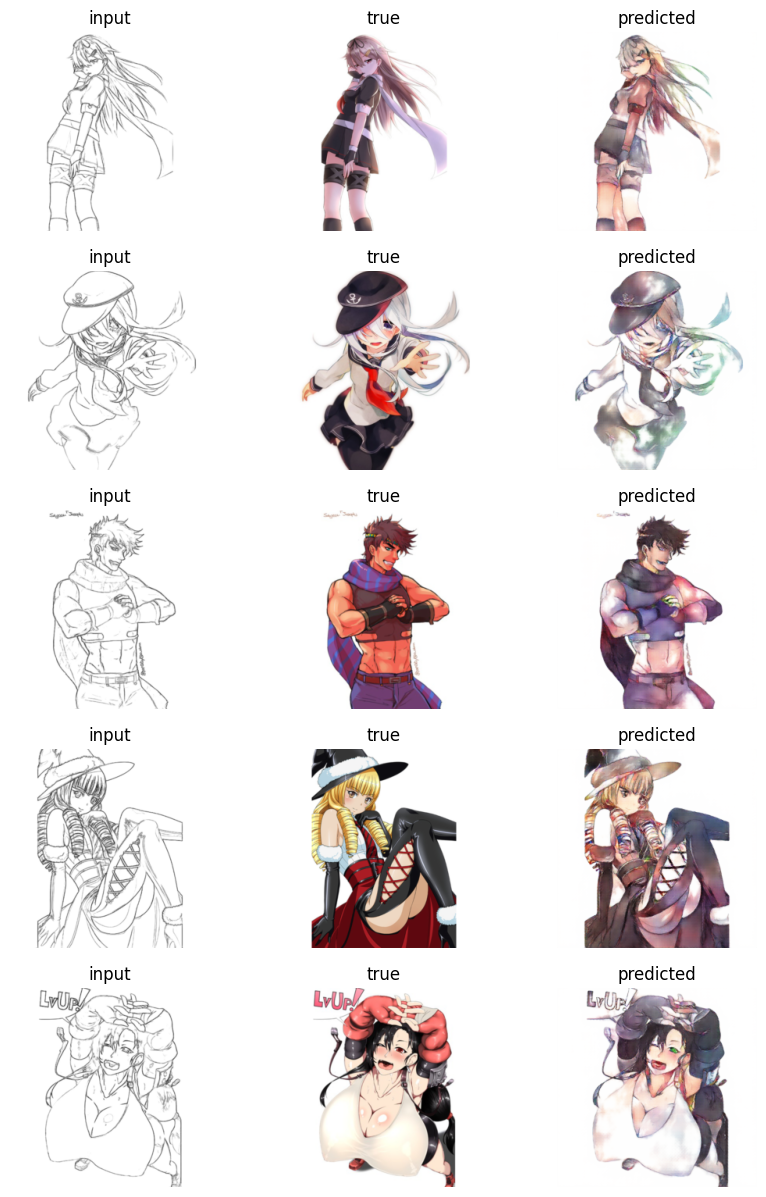

In [32]:
show_some_examples(cGAN, val_dataset)

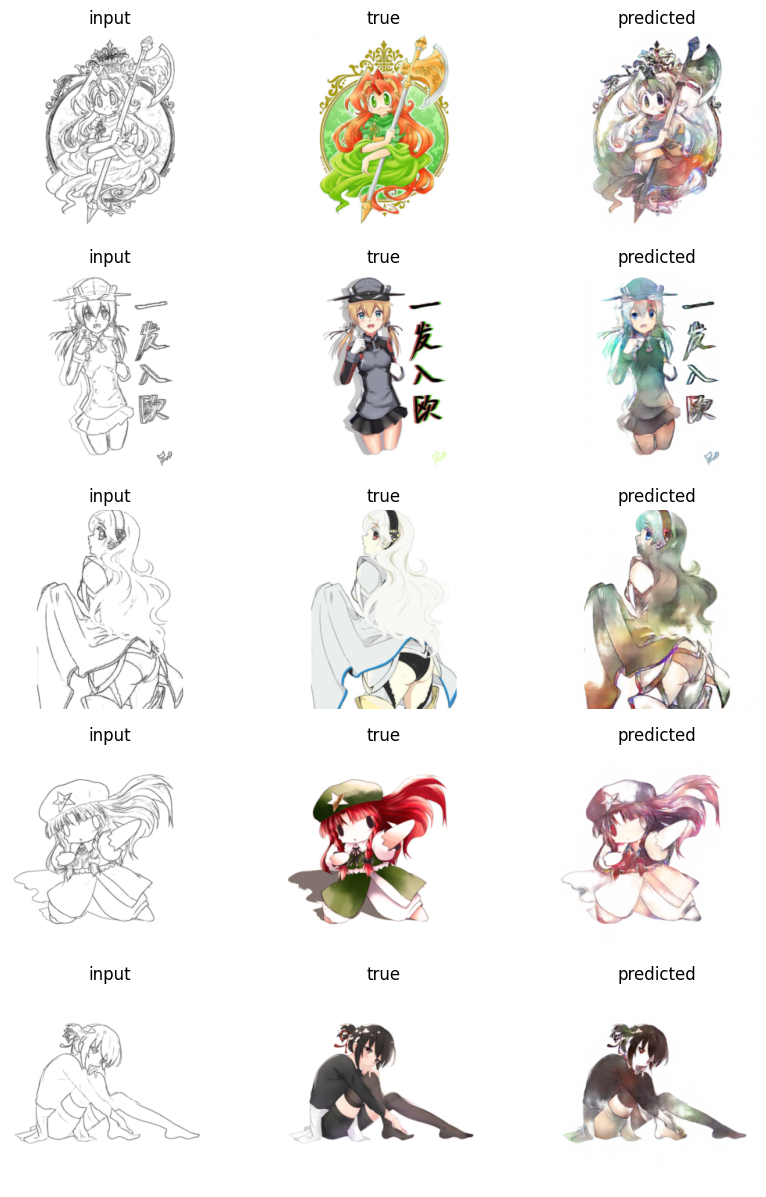

In [33]:
show_some_examples(cGAN, val_dataset)

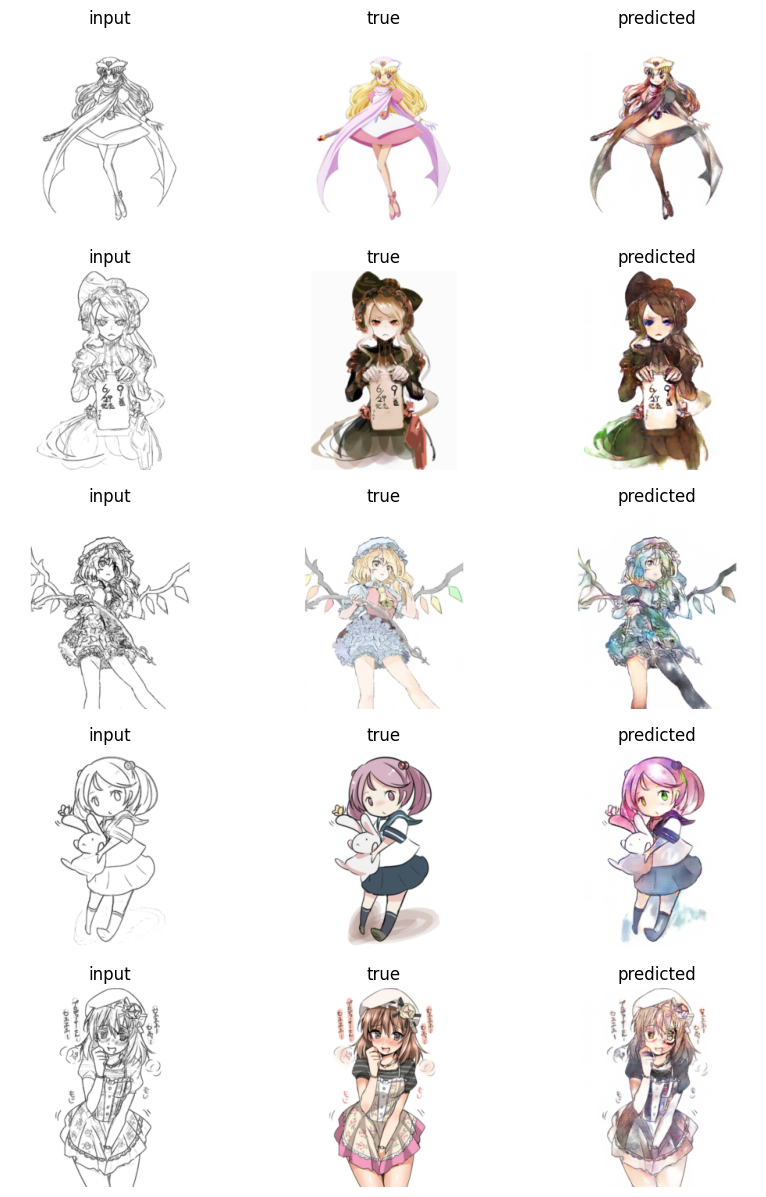

In [34]:
show_some_examples(cGAN, val_dataset)

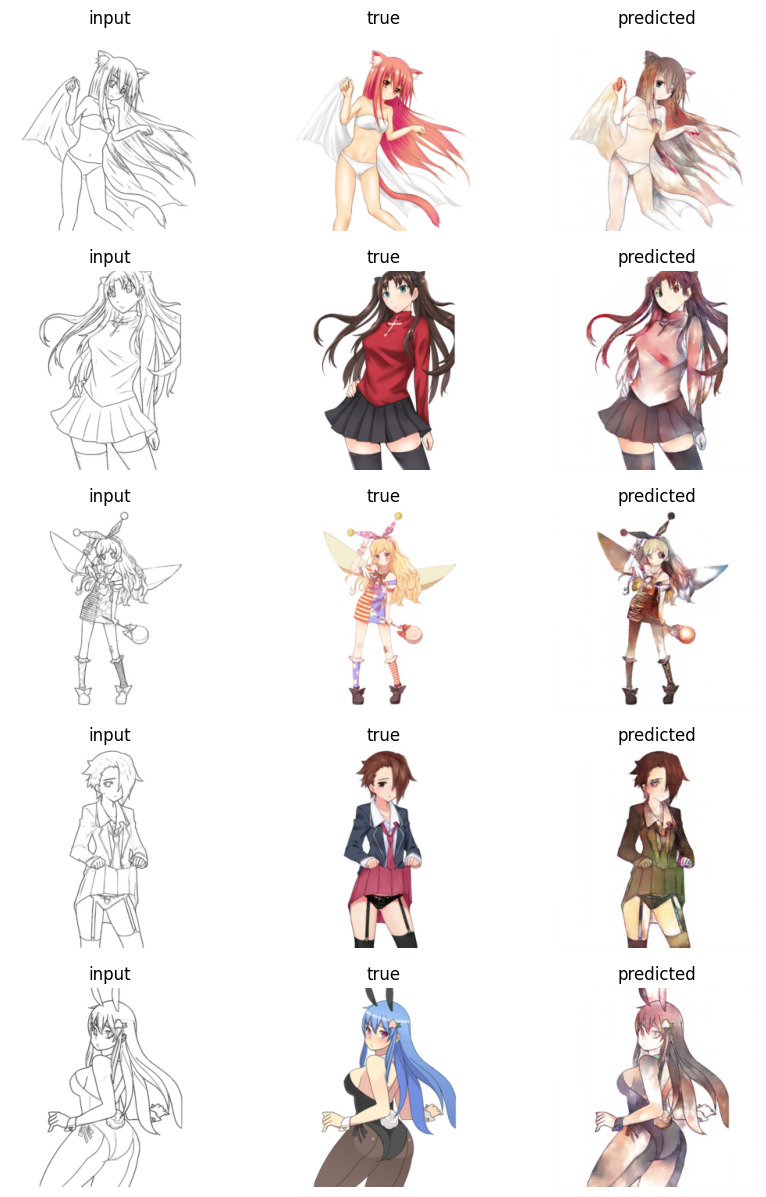

In [35]:
show_some_examples(cGAN, val_dataset)

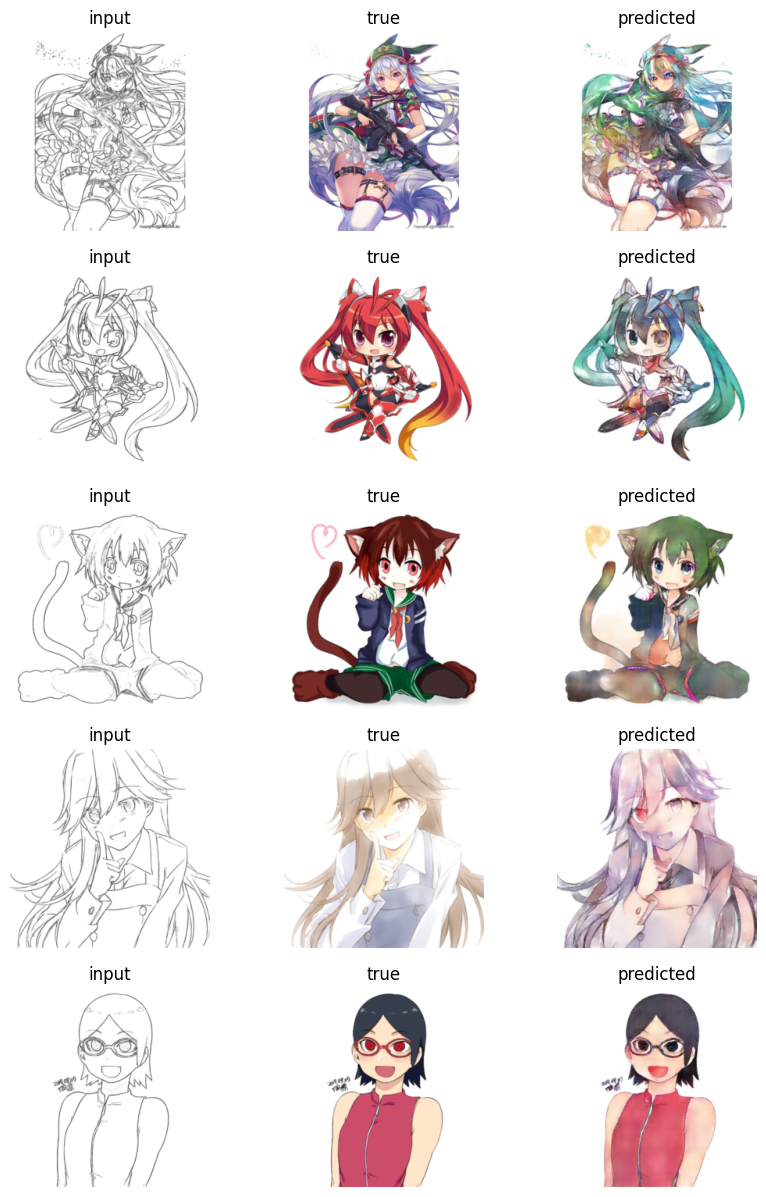

In [36]:
show_some_examples(cGAN, val_dataset)

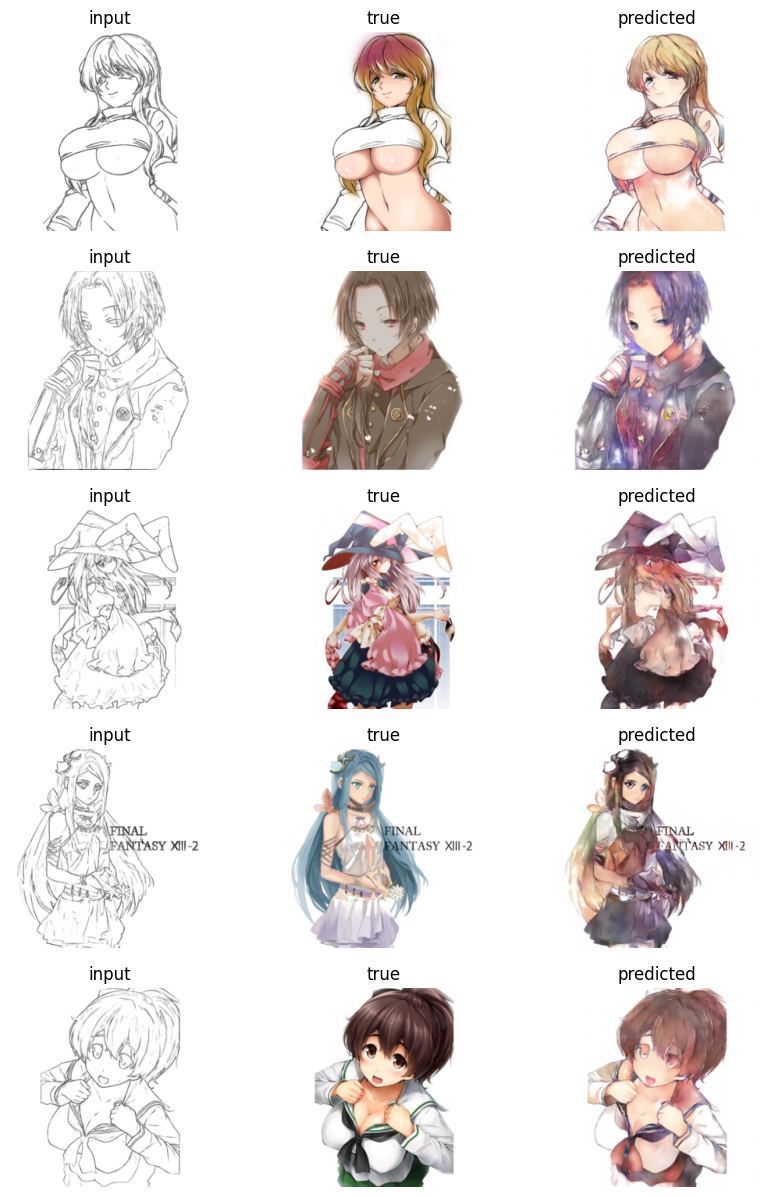

In [37]:
show_some_examples(cGAN, val_dataset)

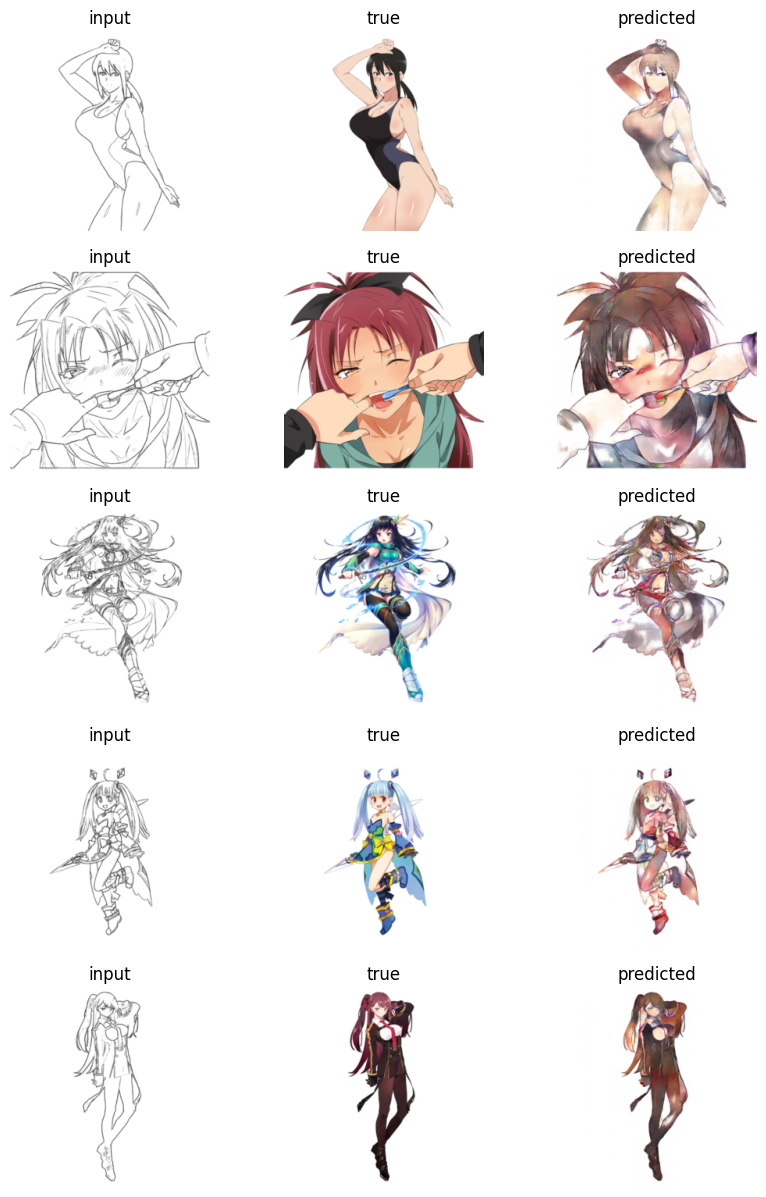

In [38]:
show_some_examples(cGAN, val_dataset)

# Overview

In this work, I trained a cGAN with BatchNorm2d, but there are some artifacts in the model's predictions. I plan to train a cGAN with InstanceNorm2d to see if this reduces the artifacts. Additionally, I plan to research how the l1_lambda parameter relates to the qualitative performance of colorization.